# Premature Optimization is the root of all evil

In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from numba import jit
import pstats
import heapq
import time
import cProfile
import pandas as pd

In [2]:
puzzle_info_path = 'puzzle_info.csv'
puzzles_path = 'puzzles.csv'
sample_submission_path = 'sample_submission.csv' # change name across board
puzzle_info_df = pd.read_csv(puzzle_info_path)
puzzles_df = pd.read_csv(puzzles_path)
sample_submission_df = pd.read_csv(sample_submission_path)

In [3]:
puzzles_df.head()

,id,puzzle_type,solution_state,initial_state,num_wildcards
0,0,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;D;A;E;B;A;B;C;A;C;A;D;C;D;F;F;F;E;E;B;F;B;C,0
1,1,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;C;B;B;E;F;A;F;D;B;F;F;E;B;D;A;A;C;D;C;E;A;C,0
2,2,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,E;F;C;C;F;A;D;D;B;B;A;F;E;B;C;A;A;B;D;F;E;E;C;D,0
3,3,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,A;C;E;C;F;D;E;D;A;A;F;A;B;D;B;F;E;D;B;F;B;C;C;E,0
4,4,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,E;D;E;D;A;E;F;B;A;C;F;D;F;D;C;A;F;B;C;C;B;E;B;A,0


In [4]:
# Parsing the initial_state and solution_state columns
# Converting the semicolon-separated string values into lists of colors
puzzles_df['parsed_initial_state'] = puzzles_df['initial_state'].apply(lambda x: x.split(';'))
seen = {}

for i in range(len(puzzles_df['parsed_initial_state'])):
    for j in range(len(puzzles_df['parsed_initial_state'][i])):
        if puzzles_df['parsed_initial_state'][i][j] not in seen:
            seen[puzzles_df['parsed_initial_state'][i][j]] = len(seen)
        puzzles_df['parsed_initial_state'][i][j] = seen[puzzles_df['parsed_initial_state'][i][j]]

puzzles_df['parsed_solution_state'] = puzzles_df['solution_state'].apply(lambda x: x.split(';'))

for i in range(len(puzzles_df['parsed_solution_state'])):
    for j in range(len(puzzles_df['parsed_solution_state'][i])):
        puzzles_df['parsed_solution_state'][i][j] = seen[puzzles_df['parsed_solution_state'][i][j]]

# Displaying the modified dataframe with parsed states
puzzles_df[['id', 'puzzle_type', 'parsed_initial_state', 'parsed_solution_state']].head()

,id,puzzle_type,parsed_initial_state,parsed_solution_state
0,0,cube_2/2/2,"[0, 1, 0, 2, 1, 3, 2, 3, 4, 2, 4, 2, 0, 4, 0, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."
1,1,cube_2/2/2,"[0, 1, 4, 3, 3, 1, 5, 2, 5, 0, 3, 5, 5, 1, 3, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."
2,2,cube_2/2/2,"[1, 5, 4, 4, 5, 2, 0, 0, 3, 3, 2, 5, 1, 3, 4, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."
3,3,cube_2/2/2,"[2, 4, 1, 4, 5, 0, 1, 0, 2, 2, 5, 2, 3, 0, 3, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."
4,4,cube_2/2/2,"[1, 0, 1, 0, 2, 1, 5, 3, 2, 4, 5, 0, 5, 0, 4, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."


In [5]:
import json

# Converting the string representation of allowed_moves to dictionary
puzzle_info_df['allowed_moves'] = puzzle_info_df['allowed_moves'].apply(lambda x: json.loads(x.replace("'", '"')))

# Selecting an example puzzle type and displaying its allowed moves
example_puzzle_type = puzzle_info_df['puzzle_type'].iloc[0]
example_allowed_moves = puzzle_info_df[puzzle_info_df['puzzle_type'] == example_puzzle_type]['allowed_moves'].iloc[0]

example_puzzle_type

'cube_2/2/2'

In [6]:
def getInversePerm(arr):
    # gets the inverse move for a certain move
    res = [0 for i in range(len(arr))]
    for i in range(len(arr)):
        res[arr[i]] = i
    return res
    
# type : (np.array(move_perm_i), np.array(name_i))
puz_info = {}

# type : {move : perm}
move_to_perm = {}

for i in range(len(puzzle_info_df)):
    puz_info[puzzle_info_df['puzzle_type'][i]] = [[], []]
    move_to_perm[puzzle_info_df['puzzle_type'][i]] = {}
    
    for j in puzzle_info_df['allowed_moves'][i].keys():
        puz_info[puzzle_info_df['puzzle_type'][i]][1].append(j)
        puz_info[puzzle_info_df['puzzle_type'][i]][0].append(np.array(puzzle_info_df['allowed_moves'][i][j]))

        puz_info[puzzle_info_df['puzzle_type'][i]][1].append(str('-' + j)) # might be the opposite
        puz_info[puzzle_info_df['puzzle_type'][i]][0].append(np.array(getInversePerm(puzzle_info_df['allowed_moves'][i][j])))

        move_to_perm[puzzle_info_df['puzzle_type'][i]][str('-' + j)] = np.array(getInversePerm(puzzle_info_df['allowed_moves'][i][j]))
        move_to_perm[puzzle_info_df['puzzle_type'][i]][j] = np.array(puzzle_info_df['allowed_moves'][i][j])

# move_to_perm['cube_2/2/2']

In [7]:
# optimize reference solution
reference_solution = pd.read_csv(sample_submission_path)
reference_solution

,id,moves
0,0,r1.-f1
1,1,f1.d0.-r0.-f1.-d0.-f1.d0.-r0.f0.-f1.-r0.f1.-d1...
2,2,f1.d0.-d1.r0.-d1.-f0.f1.-r0.-f0.-r1.-f0.r0.-d0...
3,3,-f0.-r0.-f0.-d0.-f0.f1.r0.-d1.-r0.-r1.-r0.-f1....
4,4,d1.-f1.d1.r1.-f0.d1.-d0.-r1.d1.d1.-f1.d1.-d0.-...
...,...,...
393,393,f19.f21.-f39.f20.f2.-f5.f7.-r3.f55.-f12.f65.-f...
394,394,-f31.-f22.f16.-f17.-f13.-f24.-f14.f2.f21.f44.f...
395,395,-r0.-f42.-f8.f16.-f49.f14.-f1.f56.f26.f35.f62....
396,396,f25.-f29.f46.f49.-f8.f27.f26.-f20.f2.-f20.f6.f...


In [8]:
# import random
# from tqdm import tqdm

# class Node:
#     def __init__(self, state, parent=None, move=None):
#         self.state = state
#         self.parent = parent
#         self.move = move
#         self.children = []
#         self.wins = 0
#         self.visits = 0
#         self.untried_moves = get_possible_moves(state)

#     def select_child(self):
#         # UCB1 formula for child selection
#         return max(self.children, key=lambda c: c.wins / c.visits + math.sqrt(2 * math.log(self.visits) / c.visits))

#     def add_child(self, move, state):
#         # Add a new child node for this move
#         child_node = Node(state=state, parent=self, move=move)
#         self.untried_moves.remove(move)
#         self.children.append(child_node)
#         return child_node

#     def update(self, result):
#         # Update this node with the simulation result
#         self.visits += 1
#         self.wins += result

# def get_possible_moves(state):
#     # Assuming move_perm is a global variable defining permutations for moves
#     return list(range(len(move_perm)))

# def apply_move(state, move_index):
#     # Apply the permutation defined by move_perm[move_index] to state
#     return state[move_perm[move_index]]

# def is_terminal(state, goal_state, max_dist):
#     # Check if the state is within max_dist of the goal state
#     return np.sum(state != goal_state) <= max_dist

# def monte_carlo_tree_search(idx, number_of_simulations=1000):
#     global puzzles_df, puz_info, move_perm

#     initial_state = np.array(puzzles_df['parsed_initial_state'][idx])
#     goal_state = np.array(puzzles_df['parsed_solution_state'][idx])
#     max_dist = puzzles_df['num_wildcards'][idx]
#     move_perm = np.array(puz_info[puzzles_df['puzzle_type'][idx]][0])

#     root = Node(state=initial_state)

#     for _ in tqdm(range(number_of_simulations)):
#         node = root
#         state = initial_state.copy()

#         # Selection
#         while node.untried_moves == [] and node.children != []:
#             node = node.select_child()
#             state = apply_move(state, node.move)

#         # Expansion
#         if node.untried_moves != []:
#             move = random.choice(node.untried_moves)
#             state = apply_move(state, move)
#             node = node.add_child(move, state)

#         # Simulation
#         while not is_terminal(state, goal_state, max_dist):
#             move = random.choice(get_possible_moves(state))
#             state = apply_move(state, move)

#         # Backpropagation
#         simulation_result = 1 if is_terminal(state, goal_state, max_dist) else 0
#         while node is not None:
#             node.update(simulation_result)
#             node = node.parent

#     # Return the move that leads to the best node
#     best_move = sorted(root.children, key=lambda c: c.visits)[-1].move
#     return best_move

# # Example usage:
# idx = 0  # Puzzle index
# best_move = monte_carlo_tree_search(idx)

In [36]:
@jit(nopython=True, parallel = True, fastmath = True)
def hash_perm(perm):
    base = 9973
    modb = 1000000007
    modc = 1000000009

    B, C = 0, 0
    for i in perm:
        B = (B * base) % modb + i
        C = (C * base) % modc + i

    return (B, C)

def dist(a, b):
    return np.count_nonzero(a != b)

In [37]:
# 1e6 ~ 2 seconds
mx_mem = int(1e7)
mem_idx = 0

last_state = np.zeros(mx_mem, dtype=int)
last_move = np.zeros(mx_mem, dtype=int)

print(last_state)

[0 0 0 ... 0 0 0]


In [40]:
%%time

from random import random
def a_star_search(idx):
    global mem_idx
    
    initial_state = np.array(puzzles_df['parsed_initial_state'][idx])
    goal_state = np.array(puzzles_df['parsed_solution_state'][idx])
    max_dist = puzzles_df['num_wildcards'][idx]
    move_perm = np.array(puz_info[puzzles_df['puzzle_type'][idx]][0])

    n = len(initial_state)
    m = len(move_perm)

    # Pruning 1: Over the entire tree, what is the average dist for path length? 
    # We make a branch dead if it's a lot worse than other branches of same length
    # -> don't consider branch in the first place

    avg_dist_length = np.array([-1 for i in range(400 * n)])
    n_length = np.array([0 for i in range(400 * n)])

    # Pruning 2: as tree grows larger, we want to be more selective about the paths we chose --> exponential fall-off
    # We don't want to be stuck explore paths of length 2 - 3 if our deepest path is already 10+
    # Even if there is a better path of length 2 - 3, it's unlikely to ever be explored anyways at that point
    # Temporary solution: above 70% of max_length -> automatically ok, otherwise, linearly decrease chosen probability
    # Depends a lot on the type of puzzles (# of branches per node)
    
    # Let's make 1 & 2 have a multiplicative effect

    # Edge-reduce 3: artificially reduce the number of edges per node
    # Some valid out going edges are worse than others.
    # Get rid of the ones that are significantly worse
    
    pq = []
    heapq.heappush(pq, (0, mem_idx, initial_state, 0))  # (priority, mem_idx, state, path_length)
    mem_idx += 1
    
    considered = set()
    considered.add(hash_perm(initial_state))

    while mem_idx + m < mx_mem:
        _, cur_idx, cur_state, cur_p = heapq.heappop(pq) 
        
        for i in range(m):
            nxt_state = cur_state[move_perm[i]]
            nxt_hash = hash_perm(nxt_state)
            
            if nxt_hash in considered:
                continue
            considered.add(nxt_hash)
            nxt_dist = dist(nxt_state, goal_state)
            last_state[mem_idx] = cur_idx
            last_move[mem_idx] = i

            if nxt_dist <= max_dist:
                return mem_idx

            # add logic for if nxt_dist is too large, skip
            
            priority = 1+cur_p + nxt_dist
            heapq.heappush(pq, (priority, mem_idx, nxt_state, 1+cur_p))
            mem_idx += 1
    return None

mem_idx = 0
cProfile.run('a_star_search(30)')
# print(puzzles_df['puzzle_type'][3])
# print(a_star_search(3))

# 4.1, 6.57
# 4.01, 6.smth, 

         71546141 function calls in 38.657 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 10938367    4.025    0.000    4.025    0.000 3022860735.py:1(hash_perm)
  9999988    5.626    0.000    8.062    0.000 3022860735.py:14(dist)
        1    7.961    7.961   38.657   38.657 <string>:1(<module>)
        1    0.002    0.002    0.002    0.002 <timed exec>:17(<listcomp>)
        1    0.001    0.001    0.001    0.001 <timed exec>:18(<listcomp>)
        1   15.939   15.939   30.696   30.696 <timed exec>:2(a_star_search)
        4    0.000    0.000    0.000    0.000 __init__.py:33(using_copy_on_write)
        4    0.000    0.000    0.000    0.000 base.py:5299(__contains__)
        8    0.000    0.000    0.000    0.000 common.py:367(apply_if_callable)
        4    0.000    0.000    0.001    0.000 frame.py:3856(__getitem__)
        4    0.000    0.000    0.000    0.000 frame.py:4405(_get_item_cache)
        8    0.000    0.000  

319  -->  ['l', '-r', '-r', 'l', '-r', 'l', 'r', 'l', 'l', 'l', 'r', 'l', 'r', 'r', 'r', 'r', '-l', '-l']


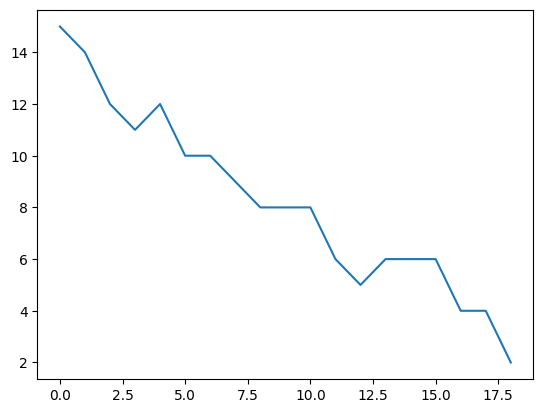

In [28]:
def dig_through_memory(idx):
    res = []
    while idx != 0:
        res.append(last_move[idx])
        idx = last_state[idx]

    res = list(reversed(res))
    return res

def solve(idx):
    global mem_idx
    
    mem_idx = 0
    
    move_name = np.array(puz_info[puzzles_df['puzzle_type'][idx]][1])

    res = a_star_search(idx)
    
    if res == None:
        return sample_submission_df['moves'][idx]

    res = dig_through_memory(res)
    for i in range(len(res)):
        res[i] = move_name[res[i]]

    return res

for i in range(319, 320):
    a = solve(i)
    print(i, " --> ", a)
    xs = [i for i in range(len(a) + 1)]
    ys = []

    goal = np.array(puzzles_df['parsed_solution_state'][i])
    cur = np.array(puzzles_df['parsed_initial_state'][i])
    ys.append(dist(cur, goal))

    for j in a:
        b = move_to_perm[puzzles_df['puzzle_type'][i]][j]
        cur = cur[b]
        ys.append(dist(cur, goal))
    
    plt.plot(xs, ys)
    plt.show()

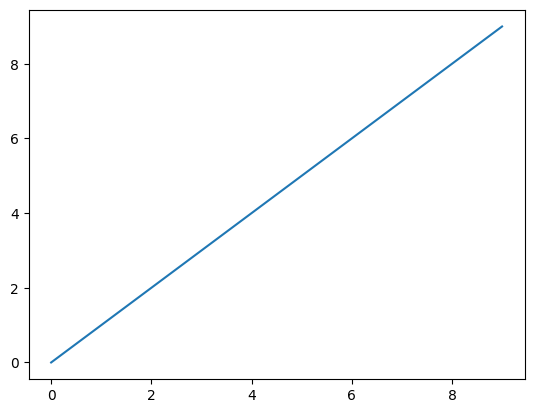

In [15]:

ys = [i for i in range(10)]
plt.plot(xs, ys)

# Step 6: Build submission format function

In [28]:
def format_solution_for_submission(puzzle_id, solution_moves):
    """
    Format the solution to a puzzle for submission.

    :param puzzle_id: The unique identifier of the puzzle.
    :param solution_moves: List of tuples representing the solution moves.
    :return: Formatted string suitable for submission.
    """
    formatted_moves = []
    for move in solution_moves:
        formatted_moves.append(move)

    # Joining the moves into a single string separated by periods
    return {'id': puzzle_id, 'moves': '.'.join(formatted_moves)}


# Step 7: Define solve function

In [29]:
from tqdm import tqdm

all_ok = []
res_df = []

for i in tqdm(range(len(puzzles_df))):
    res = solve(i)
    # print(res)
    if res == None:
        res = format_solution_for_submission(i, sample_submission_df['moves'][i].split('.'))
    else:
        all_ok.append(i)
        res = format_solution_for_submission(i, res)
    res_df.append(res)

  0%|                                                   | 0/398 [00:00<?, ?it/s]

OK : 0 16
num [6, 3]
OK : 1 13131
num [0, 6, 2, 9, 9, 2, 9, 3, 8]


  1%|▎                                          | 3/398 [00:01<03:15,  2.02it/s]

OK : 2 776542
num [3, 5, 1, 7, 1, 8, 7, 9, 0, 8, 8, 1]


  1%|▎                                          | 3/398 [00:02<05:00,  1.31it/s]


KeyboardInterrupt: 

In [ ]:
for i in tqdm(range(len(res_df), len(puzzles_df))):
    res = None
    # print(res)
    if res == None:
        res = format_solution_for_submission(i, sample_submission_df['moves'][i].split('.'))
    else:
        all_ok.append(i)
        res = format_solution_for_submission(i, res)
    res_df.append(res)

In [ ]:
print(all_ok)

In [ ]:
res_df = pd.DataFrame(res_df)
res_df

# Step 9: Save submission

In [ ]:
# Define the file path for the output CSV file
output_csv_path = 'submission.csv'

# Save the output DataFrame to a CSV file
res_df.to_csv(output_csv_path, index=False)

# Return the path of the saved file
output_csv_path